Summary of the notebook : We performed preprocessing of the data using standard scaler and label encoder, combined various datasets, found the best parameters using grid search CV to use in the logistic regression and random forest classifier model. Random forest classifier gave us the maximum accuracy of 0.55. Using this model, we could successfully predict two test cases of previous matches, which passed. The exploratory data visualisation has also been included, which earlier helped us narrow down which features to use in the prediction dataset.

In [60]:
import pandas as pd
all_seasons_summary=pd.read_csv('all_season_summary.csv')
# filtered_points_table = points_table[(points_table['season'] >= 2020) & (points_table['season'] <= 2023)]
all_seasons_summary = all_seasons_summary[(all_seasons_summary['season'] >= 2013) & (all_seasons_summary['season'] <= 2023)]

In [61]:
win_prediction_ds = pd.DataFrame()
win_prediction_ds[['season','match_id','venue_id','home_team','away_team','toss_won','decision','home_captain','away_captain','winner']] = all_seasons_summary[['season','id','venue_id','home_team','away_team','toss_won','decision','home_captain','away_captain','winner']]
columns_to_replace = ['home_team', 'away_team', 'toss_won', 'winner']
for col in columns_to_replace:
    win_prediction_ds[col] = win_prediction_ds[col].replace('KXIP', 'PBKS')
# Drop rows with NaN values in any column
win_prediction_ds.replace('', pd.NA, inplace=True)
win_prediction_ds.dropna(inplace=True)
print(win_prediction_ds)

     season  match_id  venue_id home_team away_team toss_won    decision  \
0    2023.0   1359475     57851        GT       CSK       GT  BOWL FIRST   
1    2023.0   1359476     57991      PBKS       KKR      KKR  BOWL FIRST   
2    2023.0   1359477   1070094       LSG        DC       DC  BOWL FIRST   
3    2023.0   1359478     58142       SRH        RR      SRH  BOWL FIRST   
4    2023.0   1359479     57897       RCB        MI      RCB  BOWL FIRST   
..      ...       ...       ...       ...       ...      ...         ...   
699  2013.0    598069     58142       SRH       KKR      KKR   BAT FIRST   
700  2013.0    598070     58040       CSK        MI      CSK   BAT FIRST   
701  2013.0    598071     58040        RR       SRH      SRH   BAT FIRST   
702  2013.0    598072     57980        MI        RR       RR   BAT FIRST   
703  2013.0    598073     57980       CSK        MI       MI   BAT FIRST   

          home_captain    away_captain winner  
0        Hardik Pandya        MS Dhoni 

In [62]:
points_table = pd.read_csv('points_table.csv')
points_table['short_name'] = points_table['short_name'].replace('KXIP', 'PBKS')
filtered_points_table = points_table[(points_table['season'] >= 2013) & (points_table['season'] <= 2023)]
average_points_table =  filtered_points_table.groupby(['season','short_name']).agg({'nrr': 'mean', 'matchpoints': 'mean'}).reset_index()
print(average_points_table)

    season short_name    nrr  matchpoints
0     2013        CSK  0.530         22.0
1     2013         DC -0.848          6.0
2     2013        KKR -0.095         12.0
3     2013         MI  0.441         22.0
4     2013       PBKS  0.226         16.0
..     ...        ...    ...          ...
88    2023         MI -0.044         16.0
89    2023       PBKS -0.304         12.0
90    2023        RCB  0.135         14.0
91    2023         RR  0.148         14.0
92    2023        SRH -0.590          8.0

[93 rows x 4 columns]


In [63]:
all_season_batting_card = pd.read_csv('all_season_batting_card.csv')
all_season_batting_card['home_team'] = all_season_batting_card['home_team'].replace('KXIP', 'PBKS')
all_season_batting_card['away_team'] = all_season_batting_card['away_team'].replace('KXIP', 'PBKS')
filtered_batting = all_season_batting_card[(all_season_batting_card['season'] >= 2013) & (all_season_batting_card['season'] <= 2023)]
filtered_batting = filtered_batting[(filtered_batting['strikeRate'] != '-') & (filtered_batting['strikeRate'].notnull()) & (filtered_batting['strikeRate'] != ' ')]
filtered_batting['strikeRate'] = filtered_batting['strikeRate'].astype(float)
average_batting =  filtered_batting.groupby(['season','match_id','current_innings']).agg({'strikeRate': 'mean'}).reset_index()
# pivoted_df = average_batting.pivot(index='match_id', columns='innings_id', values='strikeRate')
# # Rename the columns
# pivoted_df.reset_index(inplace=True)
# pivoted_df = pd.merge(pivoted_df, average_batting[['match_id', 'season']], on='match_id', how='left')
# # Rename the columns
# pivoted_df.columns = ['match_id', 'strikeRate1', 'strikeRate2', 'season']
# pivoted_df.drop_duplicates(inplace=True)
# print(pivoted_df)
print(average_batting)

      season  match_id current_innings  strikeRate
0     2013.0    597998              DC   70.012000
1     2013.0    597998             KKR  101.106667
2     2013.0    597999              MI  131.150000
3     2013.0    597999             RCB   68.685714
4     2013.0    598000             PWI   87.157273
...      ...       ...             ...         ...
1392  2023.0   1370351              MI  116.137778
1393  2023.0   1370352              GT  186.316000
1394  2023.0   1370352              MI  108.096364
1395  2023.0   1370353             CSK  171.152857
1396  2023.0   1370353              GT  142.542000

[1397 rows x 4 columns]


In [64]:
win_prediction_ds = win_prediction_ds.merge(average_points_table.rename(columns={'short_name': 'home_team'}),
                              how='left', on=['season','home_team'])
win_prediction_ds.rename(columns={'nrr': 'home_team_nrr', 'matchpoints': 'home_team_points'}, inplace=True)

win_prediction_ds = win_prediction_ds.merge(average_points_table.rename(columns={'short_name': 'away_team'}),
                              how='left', on=['season','away_team'])
win_prediction_ds.rename(columns={'nrr': 'away_team_nrr', 'matchpoints': 'away_team_points'}, inplace=True)

print(win_prediction_ds)

     season  match_id  venue_id home_team away_team toss_won    decision  \
0    2023.0   1359475     57851        GT       CSK       GT  BOWL FIRST   
1    2023.0   1359476     57991      PBKS       KKR      KKR  BOWL FIRST   
2    2023.0   1359477   1070094       LSG        DC       DC  BOWL FIRST   
3    2023.0   1359478     58142       SRH        RR      SRH  BOWL FIRST   
4    2023.0   1359479     57897       RCB        MI      RCB  BOWL FIRST   
..      ...       ...       ...       ...       ...      ...         ...   
695  2013.0    598069     58142       SRH       KKR      KKR   BAT FIRST   
696  2013.0    598070     58040       CSK        MI      CSK   BAT FIRST   
697  2013.0    598071     58040        RR       SRH      SRH   BAT FIRST   
698  2013.0    598072     57980        MI        RR       RR   BAT FIRST   
699  2013.0    598073     57980       CSK        MI       MI   BAT FIRST   

          home_captain    away_captain winner  home_team_nrr  \
0        Hardik Pandya 

In [65]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
label_encoder = LabelEncoder()
columns_to_encode = ['home_team','away_team','toss_won','winner']
for column in columns_to_encode:
    label_encoder.fit(win_prediction_ds[column])
    win_prediction_ds[column] = label_encoder.transform(win_prediction_ds[column])

def label_encoder_func(team_name):
  code = label_encoder.transform(team_name)
  return code


label_encoder2 = LabelEncoder()
diff_columns = ['decision','venue_id']
for column2 in diff_columns:
    win_prediction_ds[column2] = label_encoder2.fit_transform(win_prediction_ds[column2])

def decision(bowl_bat):
  enc = label_encoder2.transform(bowl_bat)
  return enc




minmax = StandardScaler()
win_prediction_ds['home_team_nrr'] = minmax.fit_transform(win_prediction_ds[['home_team_nrr']])
win_prediction_ds['away_team_nrr'] = minmax.fit_transform(win_prediction_ds[['away_team_nrr']])
win_prediction_ds['home_team_points'] = minmax.fit_transform(win_prediction_ds[['home_team_points']])
win_prediction_ds['away_team_points'] = minmax.fit_transform(win_prediction_ds[['away_team_points']])

def nrr_mp(score):
  sc = minmax.transform([score])
  return sc
print(win_prediction_ds)

     season  match_id  venue_id  home_team  away_team  toss_won  decision  \
0    2023.0   1359475         0          3          0         3         1   
1    2023.0   1359476         3          7          4         4         1   
2    2023.0   1359477        24          5          1         1         1   
3    2023.0   1359478         8         12         11        12         1   
4    2023.0   1359479         1          9          6         9         1   
..      ...       ...       ...        ...        ...       ...       ...   
695  2013.0    598069         8         12          4         4         0   
696  2013.0    598070         6          0          6         0         0   
697  2013.0    598071         6         11         12        12         0   
698  2013.0    598072         2          6         11        11         0   
699  2013.0    598073         2          0          6         6         0   

          home_captain    away_captain  winner  home_team_nrr  \
0        H

In [66]:
columns_to_drop = ['winner','match_id','home_captain','away_captain','season']
X = win_prediction_ds.drop(columns_to_drop,axis = 1)
y = win_prediction_ds['winner']
print('X',X)
print('y',y)

[]

X      venue_id  home_team  away_team  toss_won  decision  home_team_nrr  \
0           0          3          0         3         1       1.554082   
1           3          7          4         4         1      -0.654723   
2          24          5          1         1         1       0.512193   
3           8         12         11        12         1      -1.222305   
4           1          9          6         9         1       0.216495   
..        ...        ...        ...       ...       ...            ...   
695         8         12          4         4         0      -0.045466   
696         6          0          6         0         0       1.000393   
697         6         11         12        12         0       0.587606   
698         2          6         11        11         0       0.823767   
699         2          0          6         6         0       1.000393   

     home_team_points  away_team_nrr  away_team_points  
0            1.373200       1.240346          0.6494

[]

In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

# Load the dataset (example using Iris dataset)
# iris = load_iris()
# X = iris.data
# y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the logistic regression model
logistic_regression = LogisticRegression()

# Define the parameter grid to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
              'penalty': ['l1', 'l2']}  # Regularization penalty (L1 or L2)

# Define GridSearchCV with logistic regression model and parameter grid
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

Best Parameters: {'C': 0.001, 'penalty': 'l2'}
Best Score: 0.25535714285714284
Accuracy: 0.2642857142857143


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceba

In [68]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define GridSearchCV with RandomForestClassifier and parameter grid
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.5375
Mean Squared Error: 15.307142857142857
Accuracy: 0.5428571428571428


In [69]:
print(type(X_test))
classes2 = label_encoder2.classes_

# Retrieve the encoded values corresponding to each class
encoded_values2 = label_encoder2.transform(classes2)

# Create a dictionary mapping each class (team name) to its corresponding encoded value
team_encoding_dict2 = dict(zip(classes2, encoded_values2))

print("Team Encoding Dictionary 2:")
print(team_encoding_dict2)


classes = label_encoder.classes_

# Retrieve the encoded values corresponding to each class
encoded_values = label_encoder.transform(classes)

# Create a dictionary mapping each class (team name) to its corresponding encoded value
team_encoding_dict = dict(zip(classes, encoded_values))

print("Team Encoding Dictionary:")
print(team_encoding_dict)
observation = {
    'venue_id': 14,
    'home_team': 4,
    'away_team': 1,
    'toss_won': 4,
    'decision': 0,
    'home_team_nrr': nrr_mp([2.518]),
    'home_team_points': nrr_mp([6]),
    'away_team_nrr': nrr_mp([-1.347]),
    'away_team_points': nrr_mp([2])
}

# Create a DataFrame with a single observation
new_df = pd.DataFrame([observation])
new_pred = best_model.predict(new_df)
print(new_pred)


<class 'pandas.core.frame.DataFrame'>
Team Encoding Dictionary 2:
{57851: 0, 57897: 1, 57980: 2, 57991: 3, 58008: 4, 58027: 5, 58040: 6, 58056: 7, 58142: 8, 58150: 9, 58162: 10, 58204: 11, 58317: 12, 58324: 13, 58547: 14, 59392: 15, 59396: 16, 343050: 17, 377285: 18, 392627: 19, 485865: 20, 545380: 21, 601879: 22, 680295: 23, 1070094: 24}
Team Encoding Dictionary:
{'CSK': 0, 'DC': 1, 'GL': 2, 'GT': 3, 'KKR': 4, 'LSG': 5, 'MI': 6, 'PBKS': 7, 'PWI': 8, 'RCB': 9, 'RPS': 10, 'RR': 11, 'SRH': 12}
[4]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [74]:
def create_df(input_values):
  observation ={
    'venue_id': team_encoding_dict2[input_values[0]],
    'home_team': team_encoding_dict[input_values[1]],
    'away_team': team_encoding_dict[input_values[2]],
    'toss_won': team_encoding_dict[input_values[3]],
    'decision': input_values[4],
    'home_team_nrr': nrr_mp([input_values[5]]),
    'home_team_points': nrr_mp([input_values[6]]),
    'away_team_nrr': nrr_mp([input_values[7]]),
    'away_team_points': nrr_mp([input_values[8]])
  }
  new_df = pd.DataFrame([observation])
  new_pred = best_model.predict(new_df)
  print(get_new_pred)


user_input = [58547, 'KKR', 'DC', 'KKR', 0, 2.518, 6, -1.347, 2]
create_df(user_input)


[4]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [80]:
def string_to_list(input_string):
    # Split the input string by commas and convert each element to appropriate data type
    input_list = input_string.split(',')
    input_list[0] = int(input_list[0])  # Convert the first element to an integer
    input_list[4] = int(input_list[4])  # Convert the fifth element to an integer
    input_list[5] = float(input_list[5])  # Convert the sixth element to a float
    input_list[6] = int(input_list[6])  # Convert the seventh element to an integer
    input_list[7] = float(input_list[7])  # Convert the eighth element to a float
    input_list[8] = int(input_list[8])  # Convert the ninth element to an integer
    return input_list

# Example usage:
user_input_string = input("Enter the data separated by commas:")
user_input_list = string_to_list(user_input_string)
create_df(user_input_list)
#Another input tried of match on 1st april : '58324,MI,RR,RR,1,-1.423,0,1.249,6'
print("Refer to this dictionary to see team name:")
print(team_encoding_dict)


Enter the data separated by commas:58324,MI,RR,RR,1,-1.423,0,1.249,6
[11]
Refer to this dictionary to see team name:
{'CSK': 0, 'DC': 1, 'GL': 2, 'GT': 3, 'KKR': 4, 'LSG': 5, 'MI': 6, 'PBKS': 7, 'PWI': 8, 'RCB': 9, 'RPS': 10, 'RR': 11, 'SRH': 12}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.externals import joblib
joblib.dump(best_model,'model.pkl')

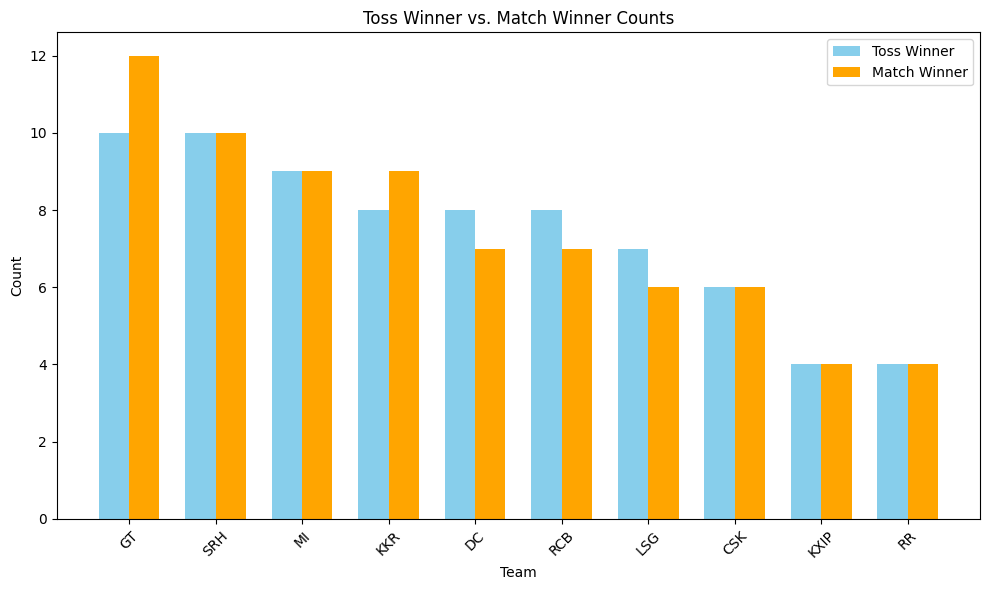

In [82]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import folium
summary_2022= pd.read_csv("season_summary.csv")
summary_2023= pd.read_csv("summary.csv")
total_summary=pd.read_csv("season_summary.csv")
import seaborn as sns

import matplotlib.pyplot as plt
toss_win_counts = total_summary['toss_won'].value_counts()
winner_counts = total_summary['winner'].value_counts()

# Set up the positions for the bars
bar_width = 0.35
index = range(len(toss_win_counts))

# Plotting the dual bar chart
plt.figure(figsize=(10, 6))

plt.bar(index, toss_win_counts.values, bar_width, color='skyblue', label='Toss Winner')
plt.bar([i + bar_width for i in index], winner_counts.values, bar_width, color='orange', label='Match Winner')

# Adding labels and legend
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Toss Winner vs. Match Winner Counts')
plt.xticks([i + bar_width/2 for i in index], toss_win_counts.index, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()




In [83]:
plt.hist(summary_2022['winner'], label='2022', alpha=.8, edgecolor='red')

# plotting second histogram
plt.hist(summary_2023['winner'], label='2023', alpha=0.7, edgecolor='yellow')
plt.legend()

# Showing the plot using plt.show()
plt.show()

In [84]:
total_matches_in_season = len(summary_2022['short_name'].unique())
print(total_matches_in_season)
summary_2022['Home Captain with Team'] = summary_2022['home_captain'] + ' (' + summary_2022['home_team'] + ')'
summary_2022['Away Captain with Team'] = summary_2022['away_captain'] + ' (' + summary_2022['away_team'] + ')'
home_captain_wins = summary_2022.groupby('Home Captain with Team')['winner'].count()
away_captain_wins = summary_2022.groupby('Away Captain with Team')['winner'].count()
total_captain_wins = home_captain_wins.add(away_captain_wins, fill_value=0)
total_captain_wins_sorted = total_captain_wins.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
total_captain_wins_sorted.plot(kind='bar', color='blue')
plt.xlabel('Captain')
plt.ylabel('Number of Wins')
plt.title('Number of Wins by Each IPL Captain 2022')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

71


In [85]:
win_counts = total_summary.groupby(['season', 'winner']).size().unstack(fill_value=0)

# Transpose the DataFrame so that teams are rows and seasons are columns
win_counts = win_counts.T

# Plotting the group bar chart
win_counts.plot(kind='bar', figsize=(12, 8))
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.title('Wins by Team Across Seasons')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()